In [1]:
import sys
sys.path.append("../..")
import torch
import numpy as np
import matplotlib.pyplot as plt
from data_utils      import *
from model_utils     import get_network
from tqdm import tqdm
import umap
from matplotlib import cm
import torchvision
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/n/fs/wy-project/miniconda3/envs/my-env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/n/fs/wy-project/miniconda3/envs/my-env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/n/fs/wy-project/miniconda3/envs/my-env/lib/python3.10/site-

In [2]:
channel, im_size, train_n_classes, test_n_classes, dst_train, dst_test = get_dataset(
        "CIFAR10",
        "../../data",
        zca=False
    )
assert train_n_classes == test_n_classes
train_loader = torch.utils.data.DataLoader(dst_train, batch_size=256, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dst_test, batch_size=256, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
test_img = []
test_label = []
with torch.no_grad():
    for x, y in tqdm(test_loader):
        test_img.append(x)
        test_label.append(y)
test_img = torch.vstack(test_img).to(device)
test_label = torch.hstack(test_label).to(device)
print(test_img.shape)
print(test_label.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.94it/s]


torch.Size([10000, 3, 32, 32])
torch.Size([10000])


In [4]:
class Resnet18_Cifar10(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.resnet = torchvision.models.resnet18(num_classes=num_classes)
        self.resnet.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.resnet.maxpool = nn.Identity()

    def forward(self, x):
        x = self.resnet(x)
        return x

train_model = Resnet18_Cifar10().to(device)
train_model.load_state_dict(torch.load(f"../../pretrained_models/resnet18.pth"))
train_model.eval()
total = 0
correct = 0
with torch.no_grad():
    for x, y in test_loader:
        x = x.cuda()
        y = y.cuda()
        pred = train_model(x)
        pred = torch.argmax(pred, dim=1)
        correct += torch.sum(pred == y).item()
        total += x.shape[0]

test_accuracy = correct/total
print(test_accuracy)


# use hooks to extract the features
info = {}
def hook1(module, input, output):
    assert len(input) == 1
    info['feat'] = input[0]
train_model.resnet.fc.register_forward_hook(hook1)

# generate test features
test_feat = []
test_pred = []
with torch.no_grad():
    for x, y in tqdm(test_loader):
        test_pred.append(train_model(x.to(device)))
        test_feat.append(info['feat'])
test_feat = torch.vstack(test_feat).detach().cpu()
test_pred = torch.vstack(test_pred).detach().cpu()

0.9079


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.20it/s]


In [5]:
# load the distilled data and extract their features
data = torch.load(f"../../DD_data/3.pt")
synthetic_data = data["data"].detach().cpu()
synthetic_label = data["label"].detach().cpu()
synthetic_pred = train_model(synthetic_data.to(device)).detach().cpu()
synthetic_feat = (info['feat']).detach().cpu()
data = torch.load(f"../../DD_data/1.pt")
synthetic_data2 = data["data"].detach().cpu()
synthetic_label2 = data["label"].detach().cpu()
synthetic_pred2 = train_model(synthetic_data2.to(device)).detach().cpu()
synthetic_feat2 = (info['feat']).detach().cpu()

([], [])

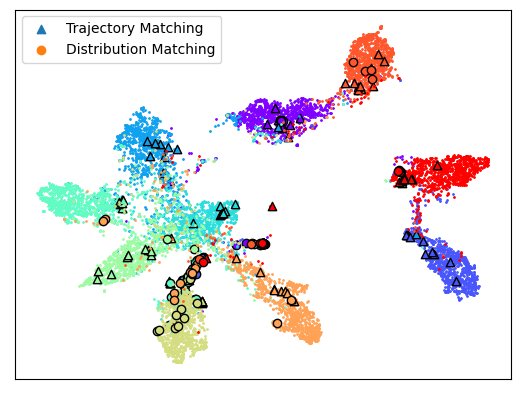

In [6]:
# generate Figure 2 (right)
import matplotlib.lines as mlines

plt.scatter([], [], marker='^', linestyle='None', label='Trajectory Matching')
plt.scatter([], [], marker='o', linestyle='None', label='Distribution Matching')

X = torch.vstack([test_feat, synthetic_feat, synthetic_feat2])
embeddings = umap.UMAP(n_neighbors=5, random_state=42).fit_transform(X)
colours = cm.rainbow(np.linspace(0, 1, 10))
for i in range(10):
    plt.scatter(embeddings[:10000,0][(test_label).detach().cpu() == i], embeddings[:10000,1][(test_label).detach().cpu() == i], s=1, color=colours[i], rasterized=True)
    plt.scatter(embeddings[10000:10100,0][(synthetic_label).detach().cpu() == i], embeddings[10000:10100,1][(synthetic_label).detach().cpu() == i], color=colours[i], marker="^", edgecolor='black', rasterized=True)
    plt.scatter(embeddings[10100:,0][(synthetic_label2).detach().cpu() == i], embeddings[10100:,1][(synthetic_label2).detach().cpu() == i], color=colours[i], marker="o", edgecolor='black', rasterized=True)
plt.legend()
plt.xticks([])
plt.yticks([])

In [7]:
# additional architecture for generation of Figure 2 (right)
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 128, 3, 1, 1)
        self.norm1 = nn.GroupNorm(128,128)
        self.conv2 = nn.Conv2d(128, 128, 3, 1, 1)
        self.norm2 = nn.GroupNorm(128,128)
        self.conv3 = nn.Conv2d(128, 128, 3, 1, 1)
        self.norm3 = nn.GroupNorm(128,128)
        self.identity = nn.Identity()
        self.fc = nn.Linear(2048, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.identity(x)
        return self.fc(x)
    
class ConvNet_tiny(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.norm1 = nn.GroupNorm(16,16)
        self.conv2 = nn.Conv2d(16, 16, 3, 1, 1)
        self.norm2 = nn.GroupNorm(16,16)
        self.conv3 = nn.Conv2d(16, 16, 3, 1, 1)
        self.norm3 = nn.GroupNorm(16,16)
        self.identity = nn.Identity()
        self.fc = nn.Linear(256, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.identity(x)
        return self.fc(x)

class Resnet34_Cifar10(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.resnet = torchvision.models.resnet34(num_classes=num_classes)
        self.resnet.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.resnet.maxpool = nn.Identity()

    def forward(self, x):
        x = self.resnet(x)
        return x
    

In [8]:
# train the smaller models and evaluate on test
train_model3 = ConvNet_tiny().to(device)
optim = torch.optim.SGD(train_model3.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
train_model3.train()
for _ in tqdm(range(20)):
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        pred = train_model3(x)
        loss = criterion(pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
    
train_model3.eval()
total = 0
correct = 0
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        pred = train_model3(x)
        pred = torch.argmax(pred, dim=1)
        correct += torch.sum(pred == y).item()
        total += x.shape[0]

test_accuracy = correct/total
print(test_accuracy)


train_model2 = ConvNet().to(device)
optim = torch.optim.SGD(train_model2.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
train_model2.train()
for _ in tqdm(range(40)):
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        pred = train_model2(x)
        loss = criterion(pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
    
train_model2.eval()
total = 0
correct = 0
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        pred = train_model2(x)
        pred = torch.argmax(pred, dim=1)
        correct += torch.sum(pred == y).item()
        total += x.shape[0]

test_accuracy = correct/total
print(test_accuracy)

# load pre-trained ResNet34 and evaluate on test
train_model4 = Resnet34_Cifar10().to(device)
train_model4.load_state_dict(torch.load(f"../../pretrained_models/resnet34.pth"))
train_model4.eval()
total = 0
correct = 0
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        pred = train_model4(x)
        pred = torch.argmax(pred, dim=1)
        correct += torch.sum(pred == y).item()
        total += x.shape[0]

test_accuracy = correct/total
print(test_accuracy)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:52<00:00,  2.63s/it]


0.6837


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:51<00:00,  2.78s/it]


0.8091
0.9276


In [9]:
# obtain the predictions from distilled data
total_results = []
for i in range(4):
    results = []
    data = torch.load(f"../../DD_data/{i}.pt")
    synthetic_data = data["data"].detach().cpu()
    synthetic_label = data["label"].detach().cpu()
    synthetic_pred = train_model(synthetic_data.to(device)).detach().cpu()
    results.append(torch.sum(torch.argmax(synthetic_pred, dim=1) == synthetic_label)/100)
    synthetic_pred = train_model2(synthetic_data.to(device)).detach().cpu()
    results.append(torch.sum(torch.argmax(synthetic_pred, dim=1) == synthetic_label)/100)
    synthetic_pred = train_model3(synthetic_data.to(device)).detach().cpu()
    results.append(torch.sum(torch.argmax(synthetic_pred, dim=1) == synthetic_label)/100)
    synthetic_pred = train_model4(synthetic_data.to(device)).detach().cpu()
    results.append(torch.sum(torch.argmax(synthetic_pred, dim=1) == synthetic_label)/100)
    total_results.append(results)

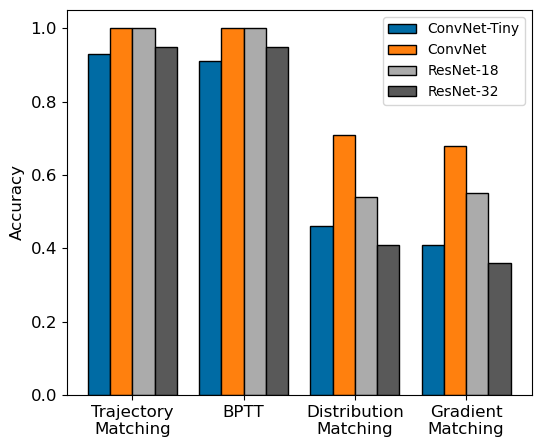

In [10]:
# generate figure
plt.rcParams.update({'font.size': 12})
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(6,5))
x = np.arange(4)
# shuffle results to the right order
temp_total_results = total_results
total_results = [temp_total_results[3], temp_total_results[0], temp_total_results[1], temp_total_results[2]]
plt.bar(x-0.2, np.array(total_results)[:,0], width=0.2, align='center', label='ConvNet-Tiny', edgecolor='black')
plt.bar(x, np.array(total_results)[:,1], width=0.2, align='center', label='ConvNet', edgecolor='black')
plt.bar(x+0.2, np.array(total_results)[:,2], width=0.2, align='center', label='ResNet-18', edgecolor='black')
plt.bar(x+0.4, np.array(total_results)[:,3],width=0.2, align='center', label='ResNet-32', edgecolor='black')
plt.xticks(x + 0.1, ["Trajectory\nMatching", "BPTT", "Distribution\nMatching", "Gradient\nMatching"])
plt.ylabel("Accuracy")
plt.legend(loc='upper right', ncol=1, fontsize='small')